# Business Goal and Problem Statement
## Loan eligibility prediction
Company should decide on giving loans for a customers, based on their application form data.

Now the process is not automated, and the company use experts to decide on loans. The company wants to automate the process. 
* Decision should be made real-time. 
* The form fields are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History, and others.

We need to:
* Create a binary classification model
* Decide if the application form should be extended
* Decide if we can switch to a fully automated decision making or use some variant of human-machine system

# Premliminary Data Analysis

In [1]:
from IPython.display import Image

In [2]:
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, model_selection, ensemble

In [3]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py

py.init_notebook_mode(connected=True)

In [4]:
matplotlib.pyplot.style.use('ggplot')
%matplotlib inline

## Data scheme review

In [5]:
# Comment for a local version
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# data = pd.read_csv('https://raw.githubusercontent.com/sdeni/IMLLesson4/main/data/loan-train.csv')
data = pd.read_csv('data/loan-train.csv')

# Data cleaning and preprocessing


In [7]:
data['Loan_Status'] = data['Loan_Status'].replace({'Y' : 1, 'N' : 0}).astype(int)
data['Property_Area'] = data['Property_Area'].replace({'Rural' : -1, 'Semiurban' : 0, 'Urban':1}).astype(int)
data['CoapplicantIncome'] = np.log(data['CoapplicantIncome'])
data['LoanAmount'] = np.log(data['LoanAmount'])
data['ApplicantIncome'] = np.log(data['ApplicantIncome'])
data['Loan_Amount_Term'] = np.log(data['Loan_Amount_Term'])
data.dropna(subset=['CoapplicantIncome', 'ApplicantIncome',  'Loan_Status', 'Loan_Amount_Term', 'LoanAmount'], inplace=True)

/home/ariel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



In [8]:
data.shape

(578, 13)

In [9]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,8.430109,7.318540,4.852030,5.886104,1.0,-1,0
2,LP001005,Male,Yes,0,Graduate,Yes,8.006368,-inf,4.189655,5.886104,1.0,1,1
3,LP001006,Male,Yes,0,Not Graduate,No,7.856707,7.765569,4.787492,5.886104,1.0,1,1
4,LP001008,Male,No,0,Graduate,No,8.699515,-inf,4.948760,5.886104,1.0,1,1
5,LP001011,Male,Yes,2,Graduate,Yes,8.597297,8.341887,5.587249,5.886104,1.0,1,1


In [10]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,578.000000,578.000000,578.000000,578.000000,529.000000,578.000000,578.000000
mean,8.342932,-inf,4.860800,5.801173,0.850662,0.025952,0.697232
std,0.649942,NaN,0.509059,0.319395,0.356759,0.781736,0.459854
min,5.010635,-inf,2.197225,2.484907,0.000000,-1.000000,0.000000
25%,7.969098,-inf,4.605170,5.886104,1.000000,-1.000000,0.000000
50%,8.246040,7.099614,4.852030,5.886104,1.000000,0.000000,1.000000
75%,8.664750,7.732368,5.123964,5.886104,1.000000,1.000000,1.000000
max,11.302204,10.637465,6.551080,6.173786,1.000000,1.000000,1.000000


In [11]:
data.describe(include = [object])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed
count,578,565,576,566,578,548
unique,578,2,2,4,2,2
top,LP002640,Male,Yes,0,Graduate,No
freq,1,459,375,323,457,471


In [12]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               2
Dependents           12
Education             0
Self_Employed        30
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

## Target function analysis

In [13]:
# data.Loan_Status = data.Loan_Status == 'Y'
# data.Loan_Status = pd.to_numeric(data.Loan_Status)

In [14]:
data.Loan_Status.value_counts()

1    403
0    175
Name: Loan_Status, dtype: int64

In [15]:
fig = go.Figure([go.Bar(x = ['yes', 'no'], y = data.Loan_Status.value_counts())])
# collab mode
#fig.show(renderer="colab")

# standalone mode
fig.show()

In [16]:
data.corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
ApplicantIncome,1.000000,0.022762,0.502809,-0.015554,0.014242,-0.013335,0.009939
CoapplicantIncome,0.022762,1.000000,0.404573,-0.051602,-0.069723,-0.019337,-0.150342
LoanAmount,0.502809,0.404573,1.000000,0.086327,-0.034802,-0.090095,-0.043341
Loan_Amount_Term,-0.015554,-0.051602,0.086327,1.000000,-0.001369,-0.081653,-0.012552
Credit_History,0.014242,-0.069723,-0.034802,-0.001369,1.000000,-0.003456,0.547439
Property_Area,-0.013335,-0.019337,-0.090095,-0.081653,-0.003456,1.000000,0.046000
Loan_Status,0.009939,-0.150342,-0.043341,-0.012552,0.547439,0.046000,1.000000


In [17]:
target_corr = data.corr()['Loan_Status']

fig = go.Figure([go.Bar(y = target_corr, x = target_corr.index, marker_color = 'red')])

fig.update_layout(xaxis_title = "Features", yaxis_title = "Correlation",
    yaxis = dict(
        range=(-1, 1),
        showticklabels=True
    ))

# collab mode
#fig.show(renderer="colab")

# standalone mode
fig.show()

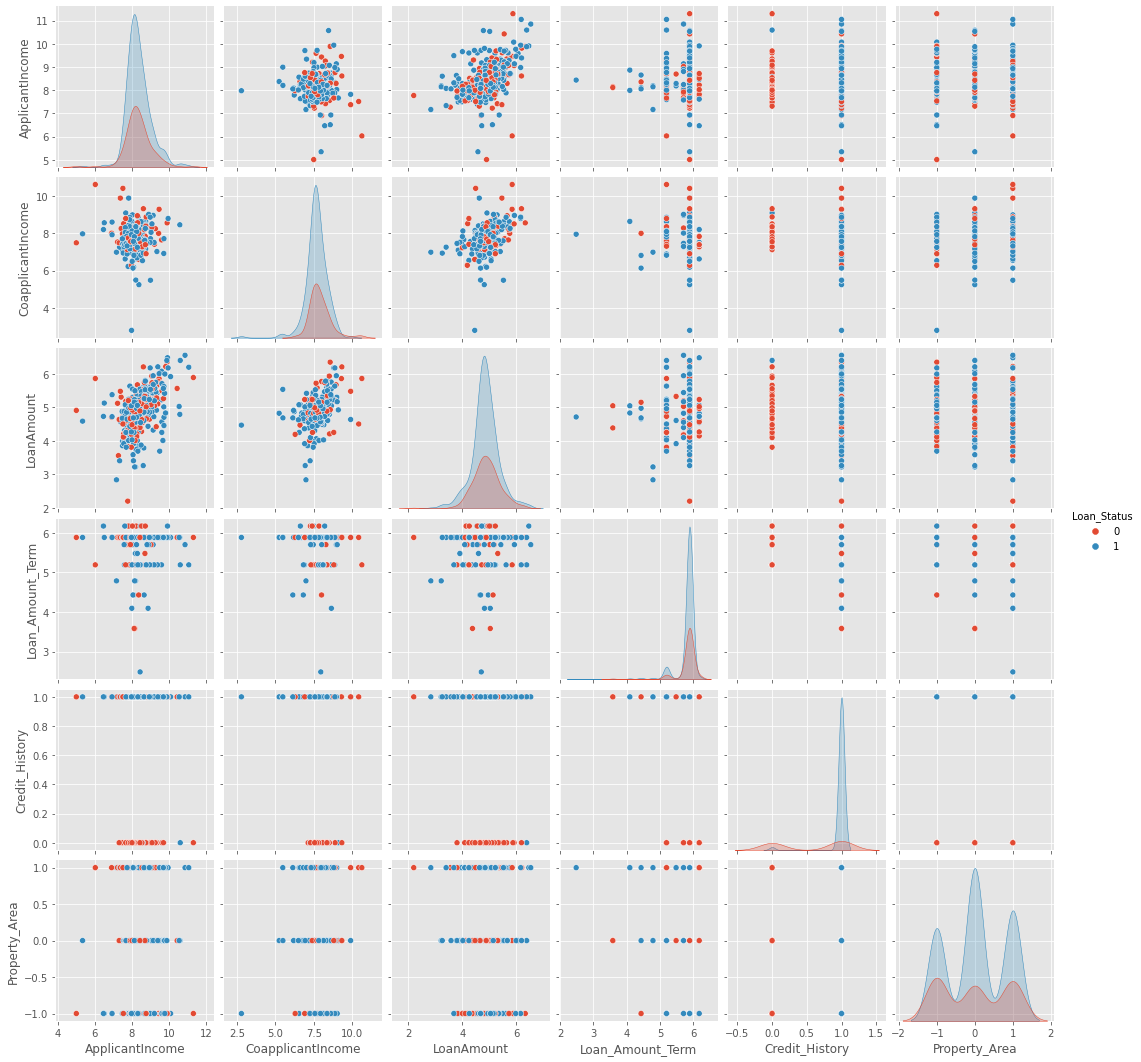

In [18]:
sns.pairplot(data.loc[:, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Property_Area']],
            hue = 'Loan_Status')

<AxesSubplot:>

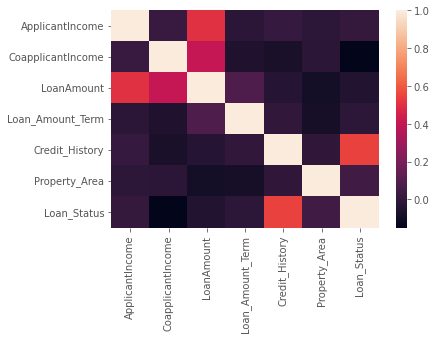

In [19]:
sns.heatmap(data.corr())

In [20]:
# lr = LogisticRegression(solver='liblinear', class_weight='balanced')

Change to category all the object columns that needed it.

In [21]:
data['Loan_Status'] = pd.Categorical(data['Loan_Status'], categories=[False, True], ordered=True)
data['Loan_Status'] = data['Loan_Status'].cat.codes
data['Married'] = pd.Categorical(data['Married'], categories=['No', 'Yes'], ordered=True)
data['Married'] = data['Married'].cat.codes
data['Dependents'] = pd.Categorical(data['Dependents'], categories=['0','1','2','3+'], ordered=True)
data['Dependents'] = data['Dependents'].cat.codes
data['Education'] = pd.Categorical(data['Education'], categories=['Graduate','Not Graduate'], ordered=True)
data['Education'] = data['Education'].cat.codes
data['Property_Area'] = pd.Categorical(data['Property_Area'], categories=['Rural','Urban','Semiurban'], ordered=True)
data['Property_Area'] = data['Property_Area'].cat.codes

In [22]:
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,1,1,0,No,8.430109,7.318540,4.852030,5.886104,1.0,-1,0
2,LP001005,Male,1,0,0,Yes,8.006368,-inf,4.189655,5.886104,1.0,-1,1
3,LP001006,Male,1,0,1,No,7.856707,7.765569,4.787492,5.886104,1.0,-1,1
4,LP001008,Male,0,0,0,No,8.699515,-inf,4.948760,5.886104,1.0,-1,1
5,LP001011,Male,1,2,0,Yes,8.597297,8.341887,5.587249,5.886104,1.0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,0,0,0,No,7.972466,-inf,4.262680,5.886104,1.0,-1,1
610,LP002979,Male,1,3,0,No,8.320205,-inf,3.688879,5.192957,1.0,-1,1
611,LP002983,Male,1,1,0,No,8.996157,5.480639,5.533389,5.886104,1.0,-1,1
612,LP002984,Male,1,2,0,No,8.933664,-inf,5.231109,5.886104,1.0,-1,1


# Summary

**Data processing:**

* Convert categorical values to numerical

* Take log of columns ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term to normalize them

* Remove Nan from columns

* In analysis we will use next columns: ('ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Property_Area')

**Model:** LogisticRegression with liblineat solver
 
**Metric:** f1-score
 
**Risks:** we make decisions based on the Loan_status column, which represent the human decision based on the same metrics, but if we want to get accurate results we should also have information of the loan status after (if it was returned or not).


# Model: Logistic Regression

In [23]:
num_data = data.select_dtypes(include = [np.number])
num_data.isnull().sum()

Married               0
Dependents            0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [24]:
print(num_data['Credit_History'].value_counts())
num_data['Credit_History'].fillna(0.0, inplace = True)
print(num_data['Credit_History'].value_counts())

1.0    450
0.0     79
Name: Credit_History, dtype: int64
1.0    450
0.0    128
Name: Credit_History, dtype: int64


In [25]:
num_data.isnull().sum()

Married              0
Dependents           0
Education            0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [26]:
num_data.isnull().values.any()

False

In [27]:
print("printing column name where infinity is present")
col_name = num_data.columns.to_series()[np.isinf(num_data).any()]
print(col_name)

printing column name where infinity is present
CoapplicantIncome    CoapplicantIncome
dtype: object


In [28]:
num_data['CoapplicantIncome'] = num_data['CoapplicantIncome'].replace({np.inf : -1, -np.inf: -1})

In [29]:
print("printing column name where infinity is present")
col_name = num_data.columns.to_series()[np.isinf(num_data).any()]
print(col_name)

printing column name where infinity is present
Series([], dtype: object)


In [30]:
# Get all the variables expect for heart disease
X = num_data.drop(columns='Loan_Status')
# Get all the heart desease
y = num_data.Loan_Status

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [32]:
# Fitting
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='liblinear', random_state=0)

In [33]:
numeric_baseline_score = model_selection.cross_val_score(
    classifier,
    X = X,
    y = y,
    cv = 5,
    scoring = 'accuracy'
    )

In [34]:
numeric_baseline_score.mean(), numeric_baseline_score.std()

(0.7682608695652174, 0.028427645293803303)